# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (3/3), done.


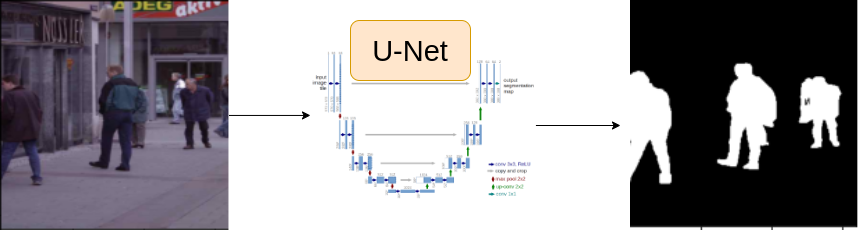

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
#Kind of like remote control of the project
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'#This specifies the path to the CSV file that contains metadata for training data, such as image file names and corresponding labels (segmentation masks).
DATA_DIR='/content/' #The script will use this directory to access image and mask files.

DEVICE='cuda' #This sets the computing device for training.

EPOCHS=25 #This specifies the number of training epochs (full passes through the dataset).
LR=0.003 #This is the learning rate, a crucial hyperparameter that controls how much the model weights are updated during training.
IMG_SIZE=320 #This defines the size to which images will be resized before being fed into the model.
BATCH_SIZE=16 #This sets the batch size, meaning that during training, the model processes 16 images at a time before updating the weights.

ENCODER='timm-efficientnet-b0' #This specifies the backbone architecture (EfficientNet-B0) used for feature extraction in a segmentation model.
WEIGHTS='imagenet' #This indicates that the model should use pre-trained weights trained on the ImageNet dataset.

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[4]

image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

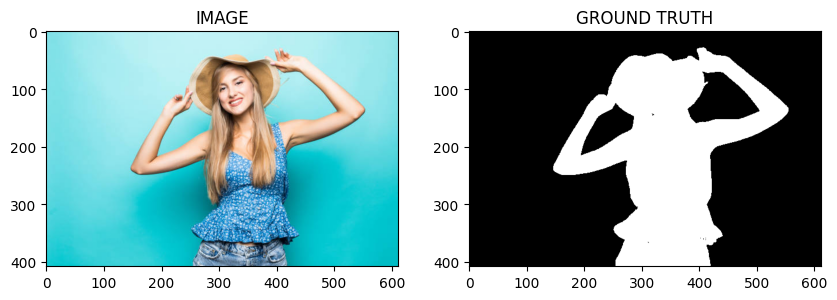

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df=train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])


# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self , df , augmentations):

    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self , idx):

    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h , w , c)
    mask=np.expand_dims(mask, axis=-1)

    # Ensure image and mask have the same dimensions
    image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image=data['image']
      mask=data['mask']

    #(h , w , c) -> (c , h , w)

    image=np.transpose(image, (2,0,1)).astype(np.float32)
    mask=np.transpose(mask, (2,0,1)).astype(np.float32)

    image=torch.Tensor(image) / 255.0
    mask=torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [ ]:
trainset= SegmentationDataset(train_df, get_train_augs())
validset= SegmentationDataset(valid_df, get_train_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 290
Size of Validset : 58


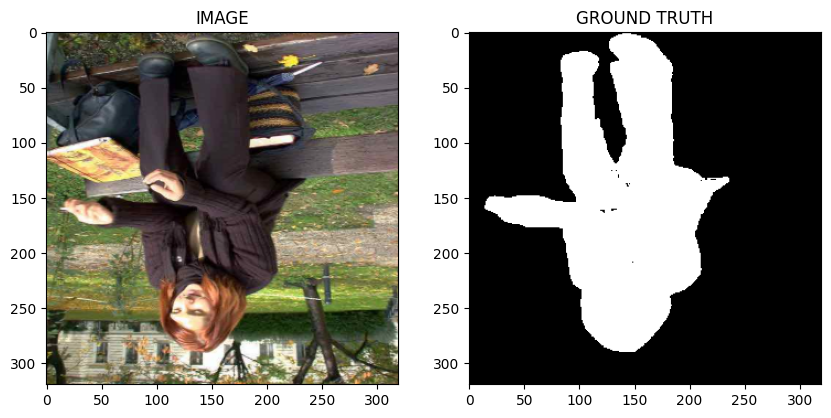

In [ ]:
idx=32
image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader: {len(trainloader)}")
print(f"Total no. of batches in validloader: {len(validloader)}")

Total no. of batches in trainloader: 19
Total no. of batches in validloader: 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")


One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):

    logits=self.arc(images)

    if masks != None:
      loss1=DiceLoss(mode='binary')(logits, masks)
      loss2=nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits


In [ ]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss=0.0

  for images, masks in tqdm(data_loader):

    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss= model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

     images=images.to(DEVICE)
     masks=masks.to(DEVICE)

     logits, loss= model(images, masks)

     total_loss += loss.item()

     return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer= torch.optim.Adam(model.parameters(),lr = LR)

In [ ]:
best_valid_loss= np.Inf

for i in range(EPOCHS):

  train_loss=train_fn(trainloader, model, optimizer)
  valid_loss=eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'bestmodel.pt')
    print("SAVED-MODEL")
    best_valid_loss=valid_loss

    print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_Loss : {valid_loss}")



  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.07671476665296052 Valid_Loss : 1.3222846984863281


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 11 Train_loss : 0.019257523511585436 Valid_Loss : 1.2604767084121704


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 13 Train_loss : 0.019826572192342656 Valid_Loss : 1.2599395513534546


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 15 Train_loss : 0.015534752293636924 Valid_Loss : 1.07149338722229


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 16 Train_loss : 0.019709668661418715 Valid_Loss : 0.6336988210678101


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 17 Train_loss : 0.01970204240397403 Valid_Loss : 0.4034733176231384


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 18 Train_loss : 0.028968139698630886 Valid_Loss : 0.2836332321166992


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 19 Train_loss : 0.02410329643048738 Valid_Loss : 0.17583686113357544


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 23 Train_loss : 0.015731933869813617 Valid_Loss : 0.16022396087646484


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 24 Train_loss : 0.017178714275360107 Valid_Loss : 0.1258106678724289


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED-MODEL
Epoch : 25 Train_loss : 0.013984212749882749 Valid_Loss : 0.11090225726366043


# Task 9 : Inference

In [ ]:
idx=2

model.load_state_dict(torch.load('/content/bestmodel.pt'))

image, mask= validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

<ipython-input-133-f57be74d6c74>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/bestmodel.pt'))


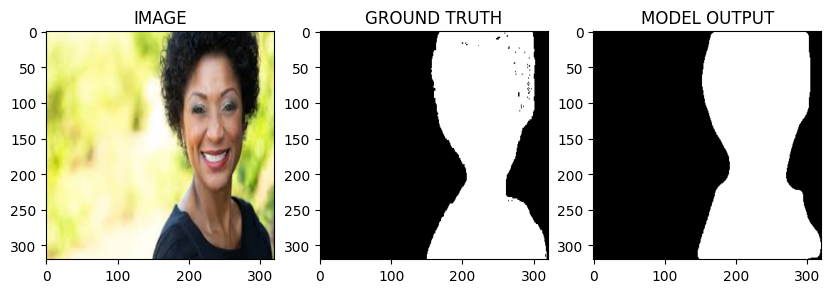

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya